In [1]:
from cnn_utils import *
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


## Data Preparation

In [2]:
df = create_dataframe('/../raw_data/dataset_062920.json')
df.head()

,eyeImage,leftEye,rightEye,y
0,"[[[0.49019607843137253, 0.4627450980392157, 0....","[-0.06916704732662149, 0.19730078279591035, -0...","[0.17425771877389162, 0.21639015714266296, 0.2...","[-0.30000000000000004, -0.3019517795637199]"
1,"[[[0.19607843137254902, 0.1607843137254902, 0....","[-0.17658285534307594, 0.18033866676032262, -0...","[0.06629549190581052, 0.1988126179958256, 0.10...","[0.30000000000000004, -0.9012629161882894]"
2,"[[[0.2196078431372549, 0.19215686274509805, 0....","[-0.17382043840055927, 0.17981051564675177, -0...","[0.06089991895895852, 0.18628686237123016, 0.0...","[0.8999999999999999, -0.9012629161882894]"
3,"[[[0.2196078431372549, 0.17647058823529413, 0....","[-0.15968611544730582, 0.18524077990937093, -0...","[0.08123800929222913, 0.1904861112443328, 0.11...","[-0.30000000000000004, 0.8989667049368542]"
4,"[[[0.5882352941176471, 0.5647058823529412, 0.6...","[-0.07825260742468576, 0.16963032408957468, -0...","[0.1666792245722788, 0.19617187288354976, 0.20...","[-0.30000000000000004, 0.2996555683122848]"


In [3]:
len(df)

846

In [4]:
x_train, x_validation, y_train, y_validation = create_train_validation(df)

In [5]:
# generate binary y labels
y_train_binary = create_binary_labels(y_train)
y_validation_binary = create_binary_labels(y_validation)# generate binary y labels
y_train_binary = create_binary_labels(y_train)
y_validation_binary = create_binary_labels(y_validation)

In [6]:
def create_tf_data(X, Y):
    """
    take in the X and Y and transform each column into np array
    """
    
    eyeImage = np.stack(X['eyeImage'].to_numpy())
    leftEye = np.stack(X['leftEye'].to_numpy())
    rightEye = np.stack(X['rightEye'].to_numpy())
    y = np.stack(Y['y'].to_numpy())
    return eyeImage, leftEye, rightEye, y

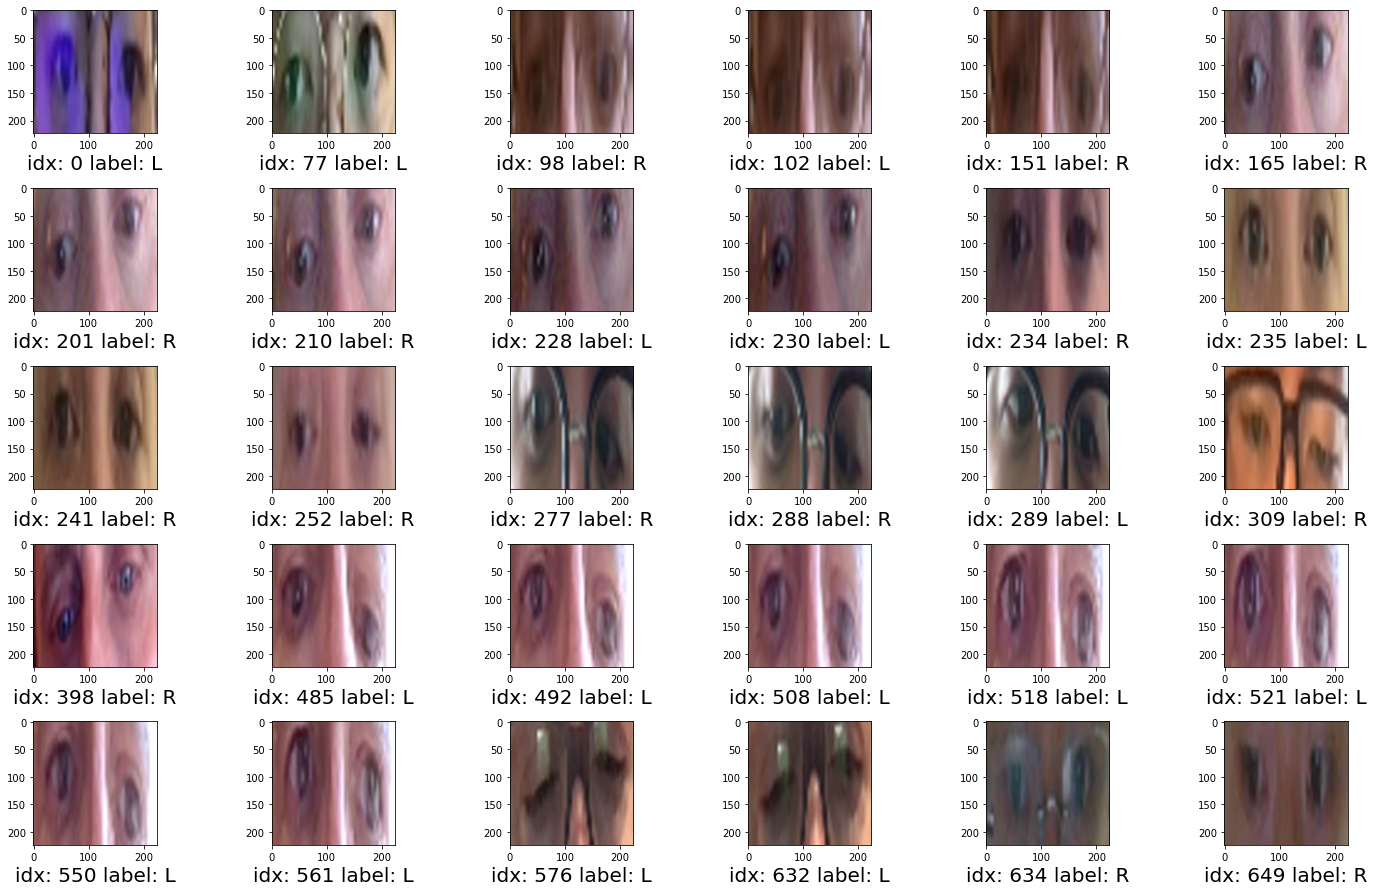

In [7]:
plot_eyeImages(x_train,y_train_binary)

In [8]:
eyeImage_train, leftEye_train, rightEye_train, binary_train = create_tf_data(x_train, y_train_binary)
eyeImage_test, leftEye_test, rightEye_test, binary_test = create_tf_data(x_validation, y_validation_binary)

In [9]:
binary_encoder = LabelEncoder()
binary_encoder.fit(binary_train)
binary_train = binary_encoder.transform(binary_train)
binary_test = binary_encoder.transform(binary_test)

In [10]:
# one-hot encoding the data
binary_train = to_categorical(binary_train)
binary_test = to_categorical(binary_test)

## VGG16 Transfer Learning

In [11]:
eyeImage = Input(shape=(224,224,3))
leftEye = Input(shape=(12)) # requires the eye positions to be flattened to 1D
rightEye = Input(shape=(12))
baseModel = VGG16(weights="imagenet", include_top=False,input_tensor=eyeImage)



Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [12]:
# place the head model on top of the base model (this will become
# the actual model we will train)
# TODO: Throw the last FC in the basemodel 
# TODO: Add meta info to the model
# TODO: Try a small learning rate
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


In [13]:
model = Model(inputs=baseModel.input, outputs=headModel)


In [14]:
for layer in baseModel.layers:
	layer.trainable = False

In [15]:
# compile our model
print("[INFO] compiling model...")
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(lr=0.0001)

model.compile(loss="binary_crossentropy", optimizer=adam, metrics=["accuracy"])

[INFO] compiling model...


In [16]:
eyeImage_train.shape

(677, 224, 224, 3)

In [17]:
# train the head of the network
print("[INFO] training head...")
history_1= model.fit(
	x = eyeImage_train,
	y = binary_train,
    validation_split=0.2,
    batch_size=32,
	epochs=10)


[INFO] training head...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 541 samples, validate on 136 samples
Epoch 1/10
541/541 [==============================] - 301s 556ms/sample - loss: 0.7687 - acc: 0.5194 - val_loss: 0.7199 - val_acc: 0.4853
Epoch 2/10
541/541 [==============================] - 295s 546ms/sample - loss: 0.7802 - acc: 0.4935 - val_loss: 0.7080 - val_acc: 0.4853
Epoch 3/10
541/541 [==============================] - 298s 550ms/sample - loss: 0.7502 - acc: 0.4954 - val_loss: 0.7042 - val_acc: 0.4853
Epoch 4/10
541/541 [==============================] - 296s 547ms/sample - loss: 0.7497 - acc: 0.5120 - val_loss: 0.7044 - val_acc: 0.4853
Epoch 5/10
541/541 [==============================] - 295s 545ms/sample - loss: 0.7703 - acc: 0.4954 - val_loss: 0.7041 - val_acc: 0.5000
Epoch 6/10
541/541 [==============================] - 298s 551ms/sample - loss: 0.7642 - acc: 0.4695 - val_loss: 0.7066 - val_acc: 0.4926
Epoch 7/

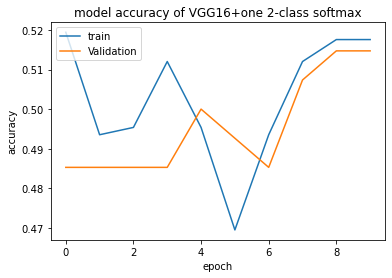

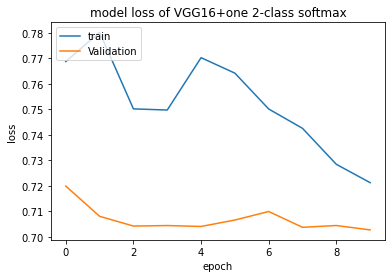

<Figure size 432x288 with 0 Axes>

In [18]:
# summarize history for accuracy
plt.plot(history_1.history['acc'])
plt.plot(history_1.history['val_acc'])
plt.title('model accuracy of VGG16+new top')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('VGG_naive_acc.png')

# summarize history for loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss of VGG16+new top')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('VGG_naive_loss.png')
